<a href="https://colab.research.google.com/github/RodrigoAVargasHdz/qaoa_maxcut/blob/main/maxcut_qaoa_ravh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QAOA for the MAX-CUT problem in Qiskt

In [3]:
!pip install qiskit --upgrade
%pip install pylatexenc


     |████████████████████████████████| 8.5MB 7.3MB/s 
     |████████████████████████████████| 17.6MB 241kB/s 
     |████████████████████████████████| 204kB 48.3MB/s 
     |████████████████████████████████| 204kB 41.8MB/s 
     |████████████████████████████████| 2.1MB 28.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 1.0MB 32.6MB/s 
     |████████████████████████████████| 194kB 37.9MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 583kB 28.5MB/s 
     |████████████████████████████████| 3.2MB 43.5MB/s 
     |████████████████████████████████| 5.5MB 44.8MB/s 
  Created wheel for qiskit: filename=qiskit-0.24.0-cp37-none-any.whl size=2918 sha256=79e764bc9c5f93d1f4146f76bb1c0c5f3481273fccfd4dce6456af405edcdf6c
  Stored in directory: /root/.cache/pip/wheels/22/fe/0a/26b7a409d1a9c3698b0319c7d009a97bffaae392d755158dca
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2

Load the following libraries. 

In [4]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram


Funciton that creates random graphs: *random_graph* \\
    **n_nodes** --> nunumber of nodes \\
    **n_edges** --> number of edges \\
    **bool_weghts** --> 
    True = random weights and False = unit weights

In [5]:
def clean_edges(n_nodes, n_edges):
    edges = np.random.randint(0,n_nodes,size=(n_edges,2)) 
#     delete duplicated edges
    unique_edges = np.unique(edges, axis=0)
#     delete edges that connect same to node
    diff = np.diff(unique_edges,axis=1) 
    i = np.where(np.abs(diff) > 0)[0]
#     final list of edfes
    edges = unique_edges[i,:]    
    return edges

def random_graph(n_nodes, n_edges,bool_weights = True):
    V = np.arange(0,n_nodes,1) # verticies
    edges = clean_edges(n_nodes, n_edges)# edges
    
    if bool_weights:
        w = np.random.random(edges.shape[0]) # randomg weigths 
    else:
        w = np.ones(edges.shape[0]) # uniform weigths 
        
    G_array = np.column_stack((edges,w)) # edges and weights
    E = tuple(tuple(g.tolist()) for g in G_array )    
    return E,V

Create a random graph

In [6]:
# numbre of nodes
n = 5 
# create a random graph
E,V = random_graph(n, 2*n,False)
print('Graph')
for e in E:
  print(e)
print(V)

Graph
(0.0, 1.0, 1.0)
(0.0, 3.0, 1.0)
(2.0, 4.0, 1.0)
(3.0, 1.0, 1.0)
(3.0, 4.0, 1.0)
[0 1 2 3 4]


Let's plot the above graph

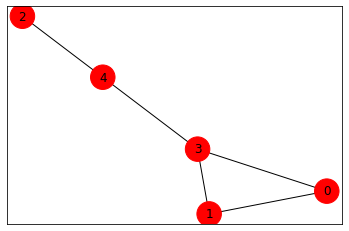

In [7]:
  G = nx.Graph()
  G.add_nodes_from(V)
  G.add_weighted_edges_from(E)

  colors = ['r' for node in G.nodes()]
  default_axes = plt.axes(frameon=True)
  pos = nx.spring_layout(G)

    # plt.figure()
  nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

The **goal** of this tutorial is to use the Quantum Approximate Optimization Algorithm (**QAOA**) algorithm to solve the **MaxCut** for a graph. 

## Coast function
As any other optimiztion algorithm, QAOA aims to maximze a cost function, 
\begin{eqnarray}
\mathbf{x}^* = \arg\max_{\mathbf{x}} \;\; C(\mathbf{x}).
\end{eqnarray}

For the MaxCut problem, $C(\cdot)$ quantifies when two nodes should belong to the same category or not. For the latter, if the edge between a pair of nodes disgree then a penalization should be included. 
A possible expression of such cost function is,
\begin{eqnarray}
C(\mathbf{x}) = \sum_{\langle i,j\rangle} C_{\langle i,j\rangle}  = \sum_{\langle i,j\rangle} \frac{1}{2}\big( 1 - g(i)g(j) \big),
\end{eqnarray}
where $g(\cdot)$ is a function that inquires if node $i$ belongs or not to a category. The sum in $C(\cdot)$ is over all edges.

We can translate the following problem into quantum computing by taking the advantage to represent each edge as a qubit, $| z \rangle =| 0 \rangle $ or $| z \rangle =| 1 \rangle $.
The quantum analog of $C$ in the compuatational basis $| z \rangle$ is,
\begin{eqnarray}
C| z \rangle &=& \sum_{\langle i,j\rangle}  C_{\langle i,j\rangle}(z)| z \rangle = C(z)| z \rangle\\
C_{\langle i,j\rangle}(z) &=& \frac{1}{2}(I - g_i \otimes g_j)| z \rangle,
\end{eqnarray}
where $g_i \otimes g_j| z \rangle = g_i | z_i\rangle \otimes g_j| z_j \rangle$. 
If $| z_i\rangle = | z_j\rangle $ then $g_i \otimes g_j = - I$. Else, $| z_i\rangle \neq | z_j\rangle $ then $g_i \otimes g_j = I$. These conditions assure that $C$ will be maximized. 
A common chose to represent $g_i \otimes g_j$ is by using the Puali Z operatros, $\sigma^Z |0\rangle  = 1$ and $\sigma^Z |1\rangle  = -1$.
By taking all this into account we can rewrite $C_{\langle i,j\rangle}$ as,
\begin{eqnarray}
C_{\langle i,j\rangle}(z) &=& \frac{1}{2}(I - \sigma^{Z}_i \otimes \sigma^{Z}_j| z \rangle.
\end{eqnarray}


In [8]:
def cost_function_C(x,G):
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
    C = 0;
    for index in E:
        e1 = int(index[0])
        e2 = int(index[1])
        w = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])      
    return C

## Introduction to QAOA


The matrix representation of $C$ is diagonal in the compuational basis $z_\rangle$, meaning $C| z\rangle = f(z)| z\rangle$. One of the diagonal elements, $| z'\rangle$, is the largest element of $C$, and we wish to find it. 

To solve for $| z'\rangle$, we constrcut an ansazt state $| \phi \rangle$, defined as, 
\begin{eqnarray}
| \phi \rangle = \sum_z a_z | z\rangle,
\end{eqnarray}
where $a_z$ are complex weiths that ensures $| \phi \rangle$ is properly normlized; $\langle \phi | \phi \rangle = \sum_z |a_z|^2 = 1$.

Under this asumption, $| \phi \rangle$ and $| z \rangle$ produce the largest expectation value of $C$,
\begin{eqnarray}
\langle z' | C | z' \rangle \approx \langle \phi | C | \phi \rangle = \sum_z f(z) |a_z|^2.
\end{eqnarray}
From the above equation we can observe that to maximize $C$ we must optimizer the coefficients $a_z$. 

## Unitary operations in the QAOA protocol
To construct the state $|\phi \rangle$, we utilze two types of rotation unitary uperators, $U(C,\gamma) = e^{-i\gamma C}$ and $U(B,\beta)= e^{-i\beta B}$.
The first step in the QAOA protocol is to linearly construct a state that is in a uniform superposition to all $|z\rangle$. The most common way to achieve this is by using the Hamadard operation,
\begin{eqnarray}
| \phi_0 \rangle = H^{\otimes n}| 0 \rangle^{\otimes n} 
\end{eqnarray}
where for a two qubit system the above expression is,
\begin{eqnarray}
| \phi_0 \rangle &=& (H_1\otimes I )| 0 \rangle_1\otimes| 0 \rangle_2 + (I\otimes H_1 )| 0 \rangle_1\otimes| 0 \rangle_2\\
 &=& \frac{1}{\sqrt{2}}\big( | 0 \rangle_1 + | 1 \rangle_1 \big)\otimes| 0 \rangle_2 + \frac{1}{\sqrt{2}} | 0 \rangle_1 \otimes\big( | 0 \rangle_2 + | 1 \rangle_2 \big).
\end{eqnarray}
The construction protocol for state $| \phi_0 \rangle$, is a standard procedure in quantum comuting. 

The next step in the QAOA protocol is to rotate $| \phi_0 \rangle$ using $U(C,\gamma)$ and $U(B,\beta)$, producing the satate $| \psi_{p}(\gamma,\beta) \rangle$.
\begin{eqnarray}
| \psi_{p=1}(\gamma,\beta) \rangle =  U(\beta,B)U(\gamma,C)| \phi_0 \rangle = e^{-i\beta B}\; e^{-i\gamma C} |\phi_0 \rangle.
\end{eqnarray}
In the QAOA algorithm we can aplly rotate the quantum state $P$-times using the same $U(C,\gamma)$ and $U(B,\beta)$ matrices with different values of $\gamma$ and $\beta$, leading to 
\begin{eqnarray}
| \psi_{P}(\boldsymbol{\gamma},\boldsymbol{\beta}) \rangle =  U(\beta_P,B)U(\gamma_P,C)\cdots U(\beta_1,B)U(\gamma_1,C)| \phi_0 \rangle,
\end{eqnarray}
where the $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$, in the lingo of machine-learning, are the hyper-parameters of the quantum circuit. 
 $\boldsymbol{\gamma}$ ($\boldsymbol{\beta}$) is the collection of all different $\gamma$s ($\beta$s); $\boldsymbol{\gamma}= [\gamma_1, \cdots,\gamma_P]$ and $\boldsymbol{\beta}= [\beta_1, \cdots,\beta_P]$.

For a sinlge rotation we can define a function like,


In [9]:
def cycle_p(q_circuit, E, V, gamma,beta):
  for edge in E:
    k = int(edge[0])
    l = int(edge[1])
    # U(C,gamma)
    q_circuit.cp(-2*gamma, k, l)
    q_circuit.p(gamma, k)
    q_circuit.p(gamma, l)
    # U(B,beta)
    q_circuit.barrier()
    q_circuit.rx(2*beta, range(len(V)))
  return q_circuit 

## $U(C,\gamma)$ and $U(B,\beta)$

Here we breifly explain both rotation matrices. 
\begin{eqnarray}
U(B,\beta) = e^{-i\beta B},
\end{eqnarray}
where $B$ is defined as,
\begin{eqnarray}
B = \sum_i \sigma^{X}_i.
\end{eqnarray}
$\sigma^{X}_i$ is the Pauli X matrix apply to the $i$-qubit.
\begin{eqnarray}
U(B,\beta) = e^{-i\beta B} = e^{-i\beta\sum_i \sigma^{X}_i} = \prod_i e^{-i\beta \sigma^{X}_i} =  \prod_i U(B_i,\beta).
\end{eqnarray}
$U(B_i,\beta)$ could be understood as a rotation operation $R_{X}$ with an angle $2 \beta$. (This is why we did, **q_circuit.rx(2*beta, range(len(V)))**).


For $U(C,\gamma)$ things are a little more complicated since, $C$ must be evaluated at each different $| z \rangle$.
\begin{eqnarray}
U(C,\gamma) = e^{-i\gamma C} = e^{i\gamma\sum_{\langle ij \rangle} C_{\langle ij \rangle}} = \prod_{\langle ij \rangle}e^{i\gamma C_{\langle ij \rangle}} =\prod_{\langle ij \rangle}  U(C_{\langle ij \rangle},\gamma),
\end{eqnarray}
where 
\begin{eqnarray}
U(C_{\langle ij \rangle},\gamma) = e^{-i \gamma \frac{1}{2} \big (I - \sigma^Z_{i} \otimes \sigma^Z_{j} \big)} = e^{-i \gamma \frac{1}{2} I} e^{i \gamma \frac{1}{2} \big (\sigma^Z_{i} \otimes \sigma^Z_{j} \big)}
\end{eqnarray}
The first term, $e^{-i \gamma \frac{1}{2} I}$, is a phase factor that could be program by a Rotation in the Z axis, $R_Z(\gamma/2)$ (code: **q_circuit.cp(-2*gamma, k, l)**).
The last term, we evaluate the terms $\sigma^Z_{i} \otimes \sigma^Z_{j}$ (code:  **q_circuit.p(gamma, k)** and **q_circuit.p(gamma, l)**).

## Coast function

From the expressions above we recall that the coast funciton $C$ is,
\begin{eqnarray}
C = \sum_{\langle i,j\rangle} C_{\langle i,j\rangle}(z) = \sum_{\langle i,j\rangle} \frac{1}{2}w_{ij}(I - \sigma^{Z}_i \otimes \sigma^{Z}_j| z \rangle,
\end{eqnarray}
where $w_{ij}$ are the weights of each edge in the graph.

The expectation value of C, $\langle C \rangle$, is the quantity we will be obtained from a quantum computer and the one we desire to maximize. 
For a $| \psi_{P}(\boldsymbol{\gamma},\boldsymbol{\beta}) \rangle$, $\langle C \rangle$ is defined as,
\begin{eqnarray}
\langle C \rangle = \langle \psi_{P}(\boldsymbol{\gamma},\boldsymbol{\beta})| \;C\;| \psi_{P}(\boldsymbol{\gamma},\boldsymbol{\beta}) \rangle
\end{eqnarray}

In [10]:
def cost_function_C(x,G):
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = int(index[0])
        e2 = int(index[1])
        
        w = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    return C

# Time to do some quantum computing simulations

1. Initialize a quantum circuit
2. Conscruct $| \psi_0 \rangle$

In [11]:
QAOA = QuantumCircuit(len(V), len(V))
QAOA.h(range(len(V)))
QAOA.barrier()

3. Define the hyper-parameters of the QAOA protocol; $\boldsymbol{Theta} =[\boldsymbol{\gamma},\boldsymbol{\beta},P]$

In [12]:
  # P = 2 (but we do not need to explicitly define it since is defined by the length of gammas_ and betas_)
  gammas_ = np.array([1.0,2.])
  betas_ = np.array([2.0,4.])


4. Construct $| \psi_{P}(\boldsymbol{\gamma},\boldsymbol{\beta}) \rangle$

In [13]:
for g,b  in zip(gammas_,betas_):
  QAOA = cycle_p(QAOA, E, V, g,b)
  QAOA.barrier()

5. Measure $\langle C \rangle$

In [14]:
QAOA.measure(range(len(V)),range(len(V)))

6. Display the quantum cirtcuit

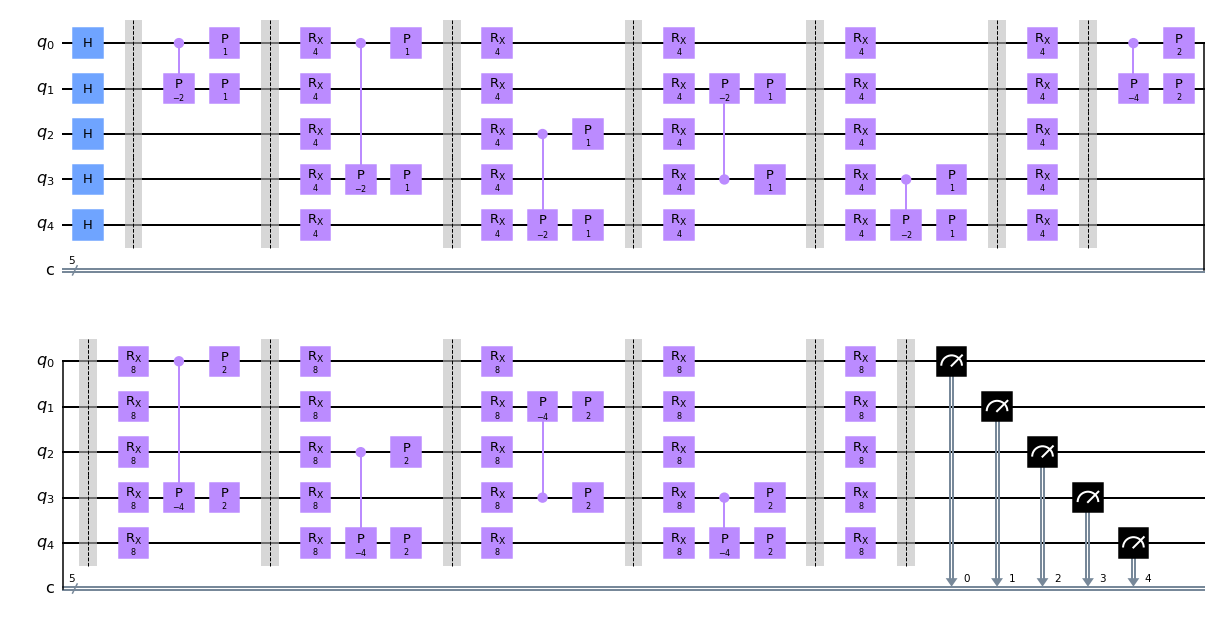

In [15]:
QAOA.draw(output='mpl')